### Additional steps

In [5]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
import matplotlib.pyplot as plt
import numpy as np

In [6]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_prepared.pkl.bz2  11_stats.pkl.bz2	    products_20200901.txt
09_stats.pkl.bz2     card_lbe.pkl.bz2	    products_20201101.txt
10_prepared.pkl.bz2  doc_lbe.pkl.bz2	    product_sum_20201001.txt
10_stats.pkl.bz2     product_groups.txt
11_prepared.pkl.bz2  products_20200901.csv


In [7]:
with bz2.open(data_path / '11_prepared.pkl.bz2', 'rb') as f:
    df = pickle.load(f)
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-11-01 15:29:01,2220AF19-3E1C-EB11-B444-005056A7539A,0,1826606,52,271,1.0,107.98,False,332351,3121751
1,2020-11-01 12:41:10,F102DC7D-261C-EB11-B444-005056A7539A,8293317,C560312,52,-9999,1.0,108.00,False,1875438,22047017
2,2020-11-01 13:17:09,4632D419-2C1C-EB11-B444-005056A7539A,0,3225041,61,379,2.0,112.00,False,563112,6419825
3,2020-11-01 12:31:31,706B9E66-251C-EB11-B444-005056A7539A,0,B700679,61,379,1.0,55.91,False,1841710,10284541
4,2020-11-01 13:06:15,71F3E090-2A1C-EB11-B444-005056A7539A,0,7024046,61,271,2.0,87.80,False,1304277,10424967


In [8]:
df.drop(['id_card', 'id_doc'], axis=1, inplace=True)
df.head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-11-01 15:29:01,0,52,271,1.0,107.98,False,332351,3121751
1,2020-11-01 12:41:10,8293317,52,-9999,1.0,108.00,False,1875438,22047017
2,2020-11-01 13:17:09,0,61,379,2.0,112.00,False,563112,6419825
3,2020-11-01 12:31:31,0,61,379,1.0,55.91,False,1841710,10284541
4,2020-11-01 13:06:15,0,61,271,2.0,87.80,False,1304277,10424967


In [9]:
with bz2.open(data_path / '11_stats.pkl.bz2', 'wb') as f:
    pickle.dump(df, f, protocol=4)

### Homework

Doing EDA on the previous week I was doing a lot of cleaning of rows instead of finding the exact outliers of cards. Let's now try to use the information I've gathered to pinpoint the cards

(**Total ids taken from**: 0 sums - high quantity, a lot of days in a row bought)

In [10]:
possible_sus = []

In [11]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [12]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2

data_path = Path('./data/').resolve()
!ls {data_path}

09_prepared.pkl.bz2  11_stats.pkl.bz2	    products_20200901.txt
09_stats.pkl.bz2     card_lbe.pkl.bz2	    products_20201101.txt
10_prepared.pkl.bz2  doc_lbe.pkl.bz2	    product_sum_20201001.txt
10_stats.pkl.bz2     product_groups.txt
11_prepared.pkl.bz2  products_20200901.csv


In [13]:
with bz2.open(data_path / '09_stats.pkl.bz2', 'rb') as f:
    one = pickle.load(f)
one.head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,0,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,0,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,0,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0,61,97,2.0,88.00,False,1065358,642341


In [14]:
with bz2.open(data_path / '10_stats.pkl.bz2', 'rb') as f:
    two = pickle.load(f)
two.head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-10-01 20:22:55,0,52,339,1.0,107.90,False,1636749,2035558
1,2020-10-01 20:54:12,0,52,339,1.0,80.04,False,267261,13037327
2,2020-10-01 21:25:59,0,61,379,1.0,31.92,True,1331395,1430590
3,2020-10-01 13:31:01,0,61,97,1.0,55.98,False,641525,3504660
4,2020-10-01 16:32:06,0,61,97,4.0,176.00,False,1325852,11024438


In [15]:
with bz2.open(data_path / '11_stats.pkl.bz2', 'rb') as f:
    three = pickle.load(f)
three.head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-11-01 15:29:01,0,52,271,1.0,107.98,False,332351,3121751
1,2020-11-01 12:41:10,8293317,52,-9999,1.0,108.00,False,1875438,22047017
2,2020-11-01 13:17:09,0,61,379,2.0,112.00,False,563112,6419825
3,2020-11-01 12:31:31,0,61,379,1.0,55.91,False,1841710,10284541
4,2020-11-01 13:06:15,0,61,271,2.0,87.80,False,1304277,10424967


In [16]:
products = pd.read_csv(
    filepath_or_buffer='data/product_groups.txt',
    sep=';'
)
products

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты
...,...,...,...
5645,40762,52194,Подарки и сувениры
5646,40763,52194,Подарки и сувениры
5647,40764,52194,Подарки и сувениры
5648,40765,52194,Подарки и сувениры


In [17]:
df = pd.concat([one, two, three])

In [18]:
df

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,0,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,0,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,0,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0,61,97,2.0,88.00,False,1065358,642341
...,...,...,...,...,...,...,...,...,...
46496617,2020-11-30 15:05:50,0,21420,12831,1.0,81.00,False,1423663,13726324
46496618,2020-11-30 13:49:02,0,22397,12657,1.0,76.00,False,406658,17134146
46496619,2020-11-30 14:44:37,0,22932,13532,1.0,34.00,False,1319934,3130473
46496620,2020-11-30 15:52:27,0,23954,12831,1.0,152.00,False,897152,10045346


### Step 0. Means of some of the values

Let's start with the mean of the quantity

In [19]:
quantity_mean = df[['id_card_int', 'quantity']].groupby('id_card_int').mean()

<AxesSubplot:>

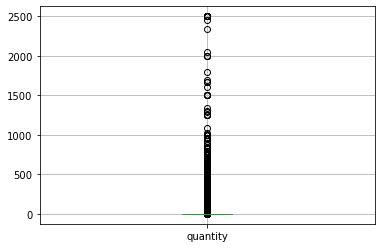

In [20]:
quantity_mean.boxplot()

Some quantityies look very shady, there is even the same maximal mean for many buyers!

In [21]:
quantity_mean[quantity_mean.quantity > 1500]

,quantity
id_card_int,
139830,1600.500000
464885,2500.500000
549510,1800.508800
664126,2500.500000
669628,2000.500000
886126,2000.500000
907726,2500.500000
937116,2050.500000
980527,1501.000000


In [22]:
df[df.id_card_int.isin(list(quantity_mean[quantity_mean.quantity > 1500].index))]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
280484,2020-09-01 12:39:13,0,1113,-9999,5000.000,0.0,False,664126,8716900
281244,2020-09-01 12:39:13,0,24643,12518,1.000,60.0,False,664126,8716900
1859135,2020-09-02 12:47:50,0,20075,15937,0.644,177.0,False,1040259,7130145
2255195,2020-09-02 17:47:44,0,173,271,1.000,52.0,False,1374648,15989275
2255624,2020-09-02 17:47:44,0,1113,-9999,5000.000,0.0,False,1374648,15989275
...,...,...,...,...,...,...,...,...,...
40922866,2020-11-27 14:37:33,0,1113,-9999,5000.000,0.0,False,1252303,17899640
40923463,2020-11-27 15:33:03,0,17826,13297,1.000,28.0,False,1252303,6583769
40923464,2020-11-27 14:37:33,0,17826,13297,1.000,28.0,False,1252303,17899640
41574848,2020-11-27 11:14:42,0,158,271,1.000,57.0,False,669628,16348785


Sum on very large quantities is equal to 0! Its very suspicious, let's check this idea

In [23]:
df[df.quantity > 700].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,10234.0,10234.0,10234.0,10234.000000,10234.0,1.023400e+04,1.023400e+04
mean,0.0,1113.0,-9999.0,3022.044167,0.0,8.814078e+05,1.172255e+07
std,0.0,0.0,0.0,1621.383868,0.0,5.257629e+05,6.753915e+06
min,0.0,1113.0,-9999.0,800.000000,0.0,1.500000e+01,3.007000e+03
25%,0.0,1113.0,-9999.0,1500.000000,0.0,4.189820e+05,5.890226e+06
50%,0.0,1113.0,-9999.0,3000.000000,0.0,9.189065e+05,1.166183e+07
75%,0.0,1113.0,-9999.0,5000.000000,0.0,1.308972e+06,1.759376e+07
max,0.0,1113.0,-9999.0,5000.000000,0.0,1.903646e+06,2.340845e+07


I don't think that this is a mistake as there are a lot of orders and most of them look normal

<AxesSubplot:>

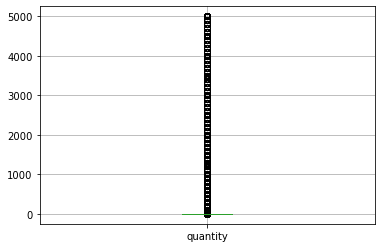

In [24]:
df[(df['sum'] == 0)][['quantity']].boxplot()

My suggestion is that it is NOT ok to get something for free with very large quantity (let's say, 100 kg or 100 'ypokavkas', it just too much. Most likely those transcation were done between shops in the internel network. I would add all of such transaction cards to outliers.

In [25]:
sus_df = df[(df.quantity > 50) & (df['sum'] == 0)]

In [26]:
len(sus_df)

14376

In [27]:
sus_df.id_card_int.nunique()

6455

Note that they also have some other purchases, but they somehow seem to have `normal` transcation but they sometimes are repeated but have different doc id. E.g. everythingn is the same but the doc id and maybe date, which makes it even more suspicious

Example:

In [28]:
df[df.id_card_int.isin(list(quantity_mean[quantity_mean.quantity == 2500.5].index))]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
280484,2020-09-01 12:39:13,0,1113,-9999,5000.0,0.0,False,664126,8716900
281244,2020-09-01 12:39:13,0,24643,12518,1.0,60.0,False,664126,8716900
2255195,2020-09-02 17:47:44,0,173,271,1.0,52.0,False,1374648,15989275
2255624,2020-09-02 17:47:44,0,1113,-9999,5000.0,0.0,False,1374648,15989275
13490609,2020-09-10 13:18:07,0,1113,-9999,5000.0,0.0,False,1500905,445156
13491247,2020-09-10 13:18:07,0,23954,12831,1.0,152.0,False,1500905,445156
15684059,2020-09-12 21:00:01,0,1113,-9999,5000.0,0.0,False,1678742,16346990
15685291,2020-09-12 21:00:01,0,31979,15448,1.0,67.0,False,1678742,16346990
34644879,2020-09-25 19:41:33,0,1113,-9999,5000.0,0.0,False,464885,414702
34645111,2020-09-25 19:41:33,0,16531,19700,1.0,44.0,False,464885,414702


In addition. All of the sales were done offline, with only 3 unique tovs (out of 14376!) and without sales

In [29]:
sus_df.drop(columns=['date', 'id_doc_int']).nunique()

id_order          1
id_tov            3
id_kontr          1
quantity         53
sum               1
is_green          1
id_card_int    6455
dtype: int64

In [30]:
possible_sus += list(sus_df.id_card_int.unique())

In [31]:
df = df[~df.id_card_int.isin(possible_sus)]

### Step 1. Investigate negative sums and quantities

Some items has negative sums and quantities

In [32]:
len(df[df['sum'] < 0]), len(df[df['quantity'] < 0])

(69, 68)

In [33]:
df[df['sum'] < 0].head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
4206092,2020-09-04 09:10:21,0,23074,19269,1.268,-470.43,False,1301664,11939194
4206102,2020-09-04 09:09:24,0,23074,19269,1.268,-470.43,False,1419650,22549976
4210124,2020-09-04 08:37:00,0,23074,19269,1.084,-402.16,False,1035577,6745380
4218019,2020-09-04 08:43:37,0,23074,19269,0.001,-0.37,False,126995,16694740
4218021,2020-09-04 08:43:37,0,23074,19269,2.375,-881.13,False,126995,16694740


In [34]:
df[df['quantity'] < 0].head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
4206093,2020-09-04 09:10:21,0,23074,19269,-1.268,470.43,False,1301664,11939194
4206103,2020-09-04 09:09:24,0,23074,19269,-1.268,470.43,False,1419650,22549976
4210123,2020-09-04 08:37:00,0,23074,19269,-1.084,402.16,False,1035577,6745380
4218020,2020-09-04 08:43:37,0,23074,19269,-0.001,0.37,False,126995,16694740
4218022,2020-09-04 08:43:37,0,23074,19269,-2.375,881.13,False,126995,16694740


They don't intersect, however

In [35]:
df[(df['quantity'] < 0) & (df['sum'] < 0)]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int


In [36]:
shady_sums = df[df['sum'] < 0][['id_card_int','sum']].groupby('id_card_int').count()

In [37]:
shady_quantities = df[df['quantity'] < 0][['id_card_int','sum']].groupby('id_card_int').count()

In [38]:
shady_sums

,sum
id_card_int,
28238,2
43295,1
48370,1
85962,1
100408,1
116276,1
126995,3
134497,1
144164,1


In [39]:
shady_quantities

,sum
id_card_int,
28238,2
43295,1
48370,1
85962,1
100408,1
116276,1
126995,3
134497,1
144164,1


If you look at them you may notice that they are similar in a way. They seems to have similar card_ids!

In [40]:
len(set(shady_sums.index) & set(shady_quantities.index))

57

In [41]:
set(shady_sums.index) - set(shady_quantities.index)

{322028}

In fact, they are! There is only one card that isn't located in both of them and it doesn't seem suspicious

In [42]:
df[df.id_card_int == 322028].describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,4.100000e+02,410.000000,410.000000,410.000000,410.000000,410.0,4.100000e+02
mean,8.033130e+04,19921.800000,14128.029268,0.953702,74.158220,322028.0,1.239418e+07
std,7.238650e+05,10100.776218,6327.495807,0.804394,68.658304,0.0,7.175884e+06
min,0.000000e+00,77.000000,-9999.000000,0.056000,-0.010000,322028.0,3.437200e+04
25%,0.000000e+00,15519.000000,12970.000000,0.600000,31.002500,322028.0,6.376123e+06
50%,0.000000e+00,20779.500000,15563.000000,1.000000,57.000000,322028.0,1.262970e+07
75%,0.000000e+00,25130.250000,17441.000000,1.000000,88.800000,322028.0,1.896390e+07
max,6.587167e+06,37885.000000,21847.000000,8.770000,426.970000,322028.0,2.319842e+07


In [43]:
df[(df.id_card_int == 322028) & (df['sum'] < 0)]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
37898334,2020-09-28 20:07:06,6587167,22492,102,1.0,-0.01,False,322028,13550999


In [44]:
shady_df = df[df.id_card_int.isin(set(shady_sums.index) & set(shady_quantities.index))]
shady_df

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
8455,2020-09-01 20:24:26,0,16777,13058,1.0,58.0,False,1419650,17055671
9718,2020-09-01 20:24:26,0,22877,18362,1.0,35.0,False,1419650,17055671
11661,2020-09-01 19:02:51,5585927,647,13567,1.0,5.0,False,1035577,20574054
13148,2020-09-01 19:02:51,5585927,19626,17391,1.0,275.0,False,1035577,20574054
14138,2020-09-01 19:02:51,5585927,23151,12744,1.0,251.0,False,1035577,20574054
...,...,...,...,...,...,...,...,...,...
46470830,2020-11-30 16:43:22,0,848,369,1.0,192.0,False,43295,16310152
46471437,2020-11-30 16:43:22,0,15353,12387,5.0,145.0,False,43295,16310152
46473079,2020-11-30 16:43:22,0,20780,15645,1.0,80.0,False,43295,16310152
46474525,2020-11-30 16:43:22,0,26780,369,1.0,84.0,False,43295,16310152


In [45]:
shady_df[['quantity', 'sum']].describe()

,quantity,sum
count,13469.000000,13469.000000
mean,1.164403,116.767056
std,0.788177,109.755977
min,-2.755000,-1022.110000
25%,1.000000,52.110000
50%,1.000000,94.500000
75%,1.000000,156.000000
max,20.000000,1659.900000


Overall looking at the orders by these cards they doesn't seem to be `very` suspicious and those negative samples might be just some technical errors (we might just remove those rows)

### Step 2. Investigate 0 sums and quantities

Although sums 0 might make sense (a present due to some event, remember that we have removed some of the malready), 0 quantities - doesnt really

In [46]:
len(df[df['sum'] == 0]), len(df[df['quantity'] == 0])

(61170, 198)

In [47]:
df[df['sum'] == 0].head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
6032,2020-09-01 10:38:06,5534007,22492,102,1.0,0.0,False,747570,1218486
6033,2020-09-01 10:15:59,5563859,22492,102,1.0,0.0,False,106917,23176383
6579,2020-09-01 15:22:32,5578751,31719,102,1.0,0.0,False,278483,15825820
13816,2020-09-01 09:53:21,5561085,22492,102,1.0,0.0,False,180463,2029875
13818,2020-09-01 15:42:31,5577896,22492,102,1.0,0.0,False,838956,21281807


In [48]:
df[df['quantity'] == 0].head()

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
76223,2020-09-01 19:48:39,5588920,15738,19687,0.0,0.79,False,116224,22979294
144688,2020-09-01 17:10:48,0,28662,19687,0.0,0.89,False,1741530,5901464
1211336,2020-09-01 19:50:39,0,23008,17616,0.0,0.51,False,974892,4375162
1649328,2020-09-02 22:07:29,0,731,17268,0.0,0.14,False,145090,5928667
2013148,2020-09-02 16:28:46,0,731,21309,0.0,0.18,False,183930,7056809


In [49]:
shady_zero_sums = df[df['sum'] == 0][['id_card_int','sum']].groupby('id_card_int').count()

In [50]:
shady_zero_quantities = df[df['quantity'] == 0][['id_card_int','sum']].groupby('id_card_int').count()

Btw two steps cards doesnt intersect

In [51]:
set(shady_zero_quantities.index) & set(shady_quantities)

set()

Its interesting how some of the cards has a lot of values

In [52]:
shady_zero_sums['sum'].describe(percentiles=[.75,.9, .95])

count    50191.000000
mean         1.218744
std          1.512908
min          1.000000
50%          1.000000
75%          1.000000
90%          1.000000
95%          2.000000
max         54.000000
Name: sum, dtype: float64

In [53]:
shady_zero_quantities['sum'].describe(percentiles=[.75,.9, .95])

count    120.000000
mean       1.650000
std        6.027458
min        1.000000
50%        1.000000
75%        1.000000
90%        1.000000
95%        2.000000
max       67.000000
Name: sum, dtype: float64

In [54]:
df[df.id_card_int==shady_zero_sums[shady_zero_sums['sum']==54].index[0]][['sum', 'quantity']].describe()

,sum,quantity
count,360.000000,360.000000
mean,87.770611,1.063883
std,104.452205,0.407579
min,0.000000,0.086000
25%,30.000000,1.000000
50%,58.805000,1.000000
75%,115.667500,1.000000
max,1000.000000,5.180000


In [55]:
df[(df.id_card_int==shady_zero_quantities[shady_zero_quantities['sum']==67].index[0]) & (df.quantity == 0)]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
38829391,2020-09-28 10:44:11,0,602,13369,0.0,0.05,False,1766517,19470147
38829396,2020-09-28 10:27:43,0,605,19230,0.0,0.12,False,1766517,3284492
38829410,2020-09-28 10:27:43,0,606,17394,0.0,0.17,False,1766517,3284492
38829429,2020-09-28 10:27:43,0,609,21399,0.0,0.24,False,1766517,3284492
38829463,2020-09-28 10:53:26,0,618,16612,0.0,0.18,False,1766517,20874220
...,...,...,...,...,...,...,...,...,...
38833017,2020-09-28 11:04:54,0,37887,16860,0.0,0.22,False,1766517,22966793
38833018,2020-09-28 12:05:41,0,37942,16860,0.0,0.22,False,1766517,21827469
38833028,2020-09-28 11:15:43,0,38186,19438,0.0,0.23,False,1766517,4533909
38833032,2020-09-28 12:05:41,0,38373,19230,0.0,0.46,False,1766517,21827469


In [56]:
df_merge = pd.merge(
    df[(df.id_card_int==shady_zero_quantities[shady_zero_quantities['sum']==67].index[0]) & (df.quantity == 0)],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [57]:
df_merge

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,id_group,name_group
0,2020-09-28 10:44:11,0,602,13369,0.0,0.05,False,1766517,19470147,10068.0,"Овощи, грибы, проростки"
1,2020-09-28 10:27:43,0,605,19230,0.0,0.12,False,1766517,3284492,10068.0,"Овощи, грибы, проростки"
2,2020-09-28 10:27:43,0,606,17394,0.0,0.17,False,1766517,3284492,10068.0,"Овощи, грибы, проростки"
3,2020-09-28 10:27:43,0,609,21399,0.0,0.24,False,1766517,3284492,10068.0,"Овощи, грибы, проростки"
4,2020-09-28 10:53:26,0,618,16612,0.0,0.18,False,1766517,20874220,10068.0,"Овощи, грибы, проростки"
...,...,...,...,...,...,...,...,...,...,...,...
62,2020-09-28 11:04:54,0,37887,16860,0.0,0.22,False,1766517,22966793,NaN,NaN
63,2020-09-28 12:05:41,0,37942,16860,0.0,0.22,False,1766517,21827469,NaN,NaN
64,2020-09-28 11:15:43,0,38186,19438,0.0,0.23,False,1766517,4533909,NaN,NaN
65,2020-09-28 12:05:41,0,38373,19230,0.0,0.46,False,1766517,21827469,NaN,NaN


Unfortunately I can't even make any clear conclusion. It's obvious that those rows should be removed, but are those customers outliers? Who knows, their other purchases looks normal.

### Step 3. How many different days the customers has actually bought something?

Idea was taking from the lab. Its obvious that normal humann being won't be able to buy a back to back several days...

In [58]:
df['day'] = df['date'].dt.date
df.head()

/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
0,2020-09-01 17:01:25,0,52,271,1.0,108.00,False,1538855,1283228,2020-09-01
1,2020-09-01 17:35:36,0,52,271,1.0,108.00,False,267307,8873113,2020-09-01
2,2020-09-01 19:19:21,0,52,271,1.0,107.95,False,610220,12712899,2020-09-01
3,2020-09-01 21:53:34,0,52,271,1.0,108.00,False,441497,21535283,2020-09-01
4,2020-09-01 18:42:31,0,61,97,2.0,88.00,False,1065358,642341,2020-09-01


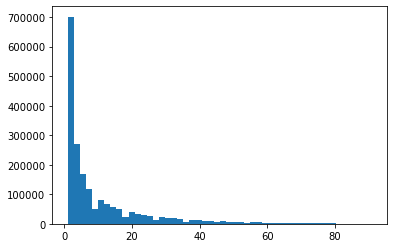

In [59]:
from matplotlib import pyplot as plt
card_unique_days = df.groupby(['id_card_int'])['day'].nunique()
card_unique_days = card_unique_days.sort_values(ascending=False)
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(card_unique_days, 50)
fig.canvas.draw()
plt.show()

Some superhumans was buying something during 91 days out of 3 months

In [60]:
card_unique_days.max()

91

<AxesSubplot:>

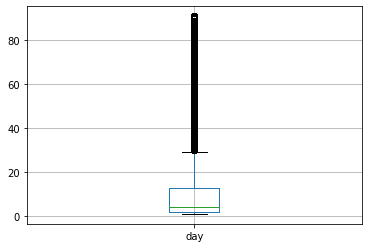

In [61]:
pd.DataFrame(card_unique_days).boxplot()

Let's consider that that everything is higher that visiting 50 days out of three month period as an outlier customer, as only 4.4% of them are in this weird range

In [62]:
bad_cards = card_unique_days[card_unique_days >= 50]
100*(len(bad_cards) / len(df))

0.04405633277264975

In [63]:
possible_sus += list(bad_cards.index)

In [66]:
df = df[~df.id_card_int.isin(possible_sus)]

In [65]:
with bz2.open(data_path / 'bad_ids.pkl.bz2', 'wb') as f:
    pickle.dump(possible_sus, f, protocol=4)

But how much money does one spent every day?

In [67]:
s = df[['id_card_int','day', 'sum', 'quantity']].groupby(['id_card_int','day']).sum()

<AxesSubplot:>

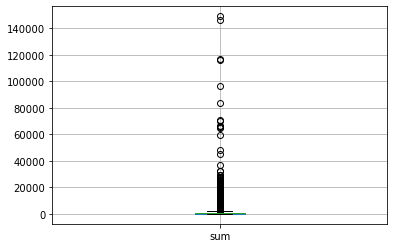

In [68]:
pd.DataFrame(s['sum']).boxplot()

Don't believe that someone would be able to spent more then 10k rubles per day

Maybe if it was someone very rich...

Let's clean them as they are clearly outliers

In [73]:
s[s['sum'] > 10000].reset_index().id_card_int.nunique()

1707

In [75]:
bad_cards = s[s['sum'] > 10000]
bad_cards = list(bad_cards.reset_index()['id_card_int'].unique())
possible_sus += bad_cards

In [79]:
with bz2.open(data_path / 'bad_ids.pkl.bz2', 'wb') as f:
    pickle.dump(possible_sus, f, protocol=4)

In [80]:
df = df[~df.id_card_int.isin(possible_sus)]

<AxesSubplot:>

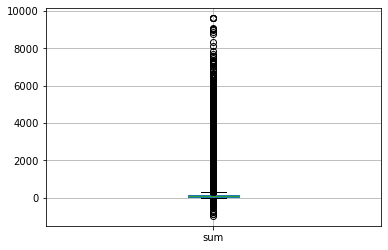

In [81]:
df[['sum', ]].boxplot()

<AxesSubplot:>

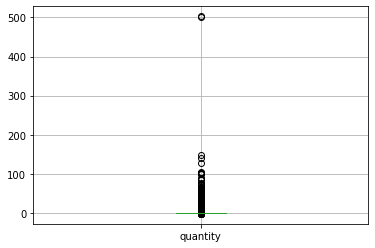

In [82]:
df[['quantity']].boxplot()

### Step 4. Strange transcations -> the customer is outlier?

In [97]:
orders_mean = df[['id_doc_int', 'sum', 'quantity']].groupby('id_doc_int').sum()

Investigating sum will most likely (it won't, i checked but deleted it) won't yield anything useful, but there is something strange with the quantity

<AxesSubplot:>

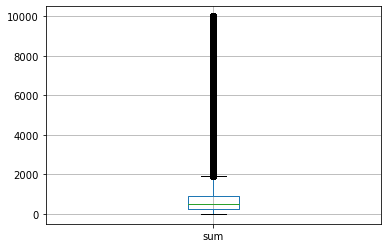

In [98]:
orders_mean[['sum']].boxplot()

<AxesSubplot:>

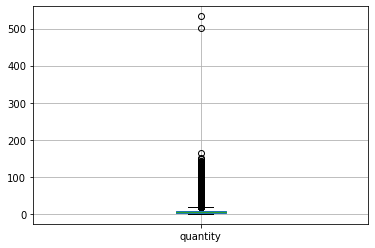

In [101]:
orders_mean[['quantity']].boxplot()

In [110]:
orders_mean[orders_mean['quantity'] > 200]

,sum,quantity
id_doc_int,,
18506190,4867.0,533.2
22725888,2304.6,501.0


In [112]:
df[df.id_doc_int==18506190]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
45125436,2020-10-31 12:50:48,0,603,17394,0.738,24.43,False,1751199,18506190,2020-10-31
45125445,2020-10-31 12:50:48,0,605,19230,0.862,23.02,False,1751199,18506190,2020-10-31
45125460,2020-10-31 12:50:48,0,606,17394,0.634,26.23,False,1751199,18506190,2020-10-31
45125549,2020-10-31 12:50:48,0,647,-9999,503.000,2313.80,False,1751199,18506190,2020-10-31
45125648,2020-10-31 12:50:48,0,1061,189,1.000,57.02,False,1751199,18506190,2020-10-31
45125685,2020-10-31 12:50:48,0,1621,12091,1.000,207.86,False,1751199,18506190,2020-10-31
45125769,2020-10-31 12:50:48,0,15039,13084,1.976,541.58,False,1751199,18506190,2020-10-31
45125827,2020-10-31 12:50:48,0,15495,12162,1.000,171.07,False,1751199,18506190,2020-10-31
45125888,2020-10-31 12:50:48,0,16039,12687,1.000,51.50,False,1751199,18506190,2020-10-31
45126138,2020-10-31 12:50:48,0,18800,13886,1.000,128.76,False,1751199,18506190,2020-10-31


In [106]:
df[df.id_doc_int==22725888]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
45125569,2020-10-31 12:57:12,0,647,-9999,501.0,2304.6,False,1751199,22725888,2020-10-31


In [113]:
pd.merge(
    df[df.id_doc_int==22725888],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day,id_group,name_group
0,2020-10-31 12:57:12,0,647,-9999,501.0,2304.6,False,1751199,22725888,2020-10-31,10155,Упаковка


Someone really likes ypakovkas very much

Let's check how they are doing

In [120]:
df[df.id_tov==647][['sum', 'quantity']].describe(percentiles=[0.9,0.95]).drop('count')

,sum,quantity
mean,5.866166,1.179356
std,2.879930,0.588424
min,0.000000,1.000000
50%,5.000000,1.000000
90%,10.000000,2.000000
95%,10.000000,2.000000
max,2313.800000,503.000000


Having ypakovka cost more then 5 and buying more then 2 (maybe 10) is too much, most likely the customers that buy more may be outliers, maybe not. Im not conclusive, therefore won't include them

In [122]:
df[(df.id_tov==647) & (df.quantity > 50)]

,date,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,day
21440462,2020-09-16 10:20:02,6054725,647,13567,55.0,275.00,False,219195,10115145,2020-09-16
29227917,2020-09-22 09:52:49,0,647,-9999,101.0,505.00,False,197475,12592218,2020-09-22
32342101,2020-09-24 16:53:32,0,647,-9999,51.0,255.00,False,1071234,21592350,2020-09-24
33114325,2020-09-24 20:26:59,6424640,647,-9999,55.0,275.00,False,1054598,22113347,2020-09-24
41623431,2020-09-30 08:33:09,0,647,-9999,54.0,270.00,False,780038,15466478,2020-09-30
10157615,2020-10-07 16:30:39,6960367,647,13362,55.0,275.00,False,1643694,11012293,2020-10-07
20848986,2020-10-15 13:44:35,7340710,647,-9999,66.0,328.71,False,704361,6538485,2020-10-15
26765838,2020-10-19 19:06:41,0,647,13567,100.0,485.00,False,122400,20528747,2020-10-19
45125549,2020-10-31 12:50:48,0,647,-9999,503.0,2313.80,False,1751199,18506190,2020-10-31
45125569,2020-10-31 12:57:12,0,647,-9999,501.0,2304.60,False,1751199,22725888,2020-10-31


### Final

In [125]:
with bz2.open(data_path / 'bad_ids.pkl.bz2', 'wb') as f:
    pickle.dump(possible_sus, f, protocol=4)

Possible cards that are outliers

In [126]:
len(possible_sus)

66554

We removed around 3 mils of rows by removing the outliers

In [127]:
len(df)

106667260